In [100]:
!ls /workspace/zhaoty/dataset/ligo_H1_test | wc -l

20


## `gwtoolkit.gw.hdffiles.sampleing`

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gwtoolkit.gw import readligo as rl
from gwtoolkit.gw import hdffiles as hd
from scipy.signal import find_peaks

In [2]:
datadir = '/workspace/zhaoty/dataset/ligo_H1_test'
num = 120
signal_length = 8 # sec
random_seed = 42
original_sampling_rate = 16384
target_sampling_rate = 4096

noise_interval = 4096
delta_t = noise_interval//2
# delta_t (int): The number of seconds around `gps_time`
#                 which we also want to be valid (because the sample will
#                 be an interval).
dq_bits=(0, 1, 2, 3)
inj_bits=(0, 1, 2, 4)

filelist = rl.FileList(directory=datadir)
noise_timeline = hd.NoiseTimeline(background_data_directory=datadir,
                                  random_seed=random_seed)

Using data directory /workspace/zhaoty/dataset/ligo_H1_test ...


In [3]:
len(noise_timeline.hdf_file_paths), noise_timeline.hdf_file_paths[0]

(20,
 '/workspace/zhaoty/dataset/ligo_H1_test/H-H1_LOSC_16_V1-1126162432-4096.hdf5')

In [4]:
len(noise_timeline.hdf_files), noise_timeline.hdf_files[-3:]

(20,
 [{'file_path': '/workspace/zhaoty/dataset/ligo_H1_test/H-H1_LOSC_16_V1-1126154240-4096.hdf5',
   'start_time': 1126154240,
   'detector': 'H1',
   'duration': 4096,
   'inj_mask': array([31, 31, 31, ..., 31, 31, 31], dtype=int32),
   'dq_mask': array([127, 127, 127, ..., 127, 127, 127], dtype=int32)},
  {'file_path': '/workspace/zhaoty/dataset/ligo_H1_test/H-H1_LOSC_16_V1-1126158336-4096.hdf5',
   'start_time': 1126158336,
   'detector': 'H1',
   'duration': 4096,
   'inj_mask': array([31, 31, 31, ..., 31, 31, 31], dtype=int32),
   'dq_mask': array([127, 127, 127, ..., 127, 127, 127], dtype=int32)},
  {'file_path': '/workspace/zhaoty/dataset/ligo_H1_test/H-H1_LOSC_16_V1-1126162432-4096.hdf5',
   'start_time': 1126162432,
   'detector': 'H1',
   'duration': 4096,
   'inj_mask': array([31, 31, 31, ..., 31, 31, 31], dtype=int32),
   'dq_mask': array([127, 127, 127, ...,   0,   0,   0], dtype=int32)}])

In [5]:
noise_timeline.timeline

{'h1_inj_mask': array([31, 31, 31, ..., 31, 31, 31], dtype=int32),
 'l1_inj_mask': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'h1_dq_mask': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'l1_dq_mask': array([0, 0, 0, ..., 0, 0, 0], dtype=int32)}

In [6]:
%%time
noise_timeline.sample(delta_t=delta_t, dq_bits=dq_bits,
                      inj_bits=inj_bits, return_paths=False)

CPU times: user 7.15 s, sys: 256 ms, total: 7.4 s
Wall time: 7.4 s


1126109184

In [7]:
# 考察占据的大小
from sys import getsizeof
getsizeof(noise_timeline.timeline['h1_inj_mask'])/1024/1024 # MB

0.35947418212890625

In [8]:
dq_bits_temp = ()
print('7 bits in the data quality bitmask:')
for i in range(7):
    dq_bits_temp += (i,)
    print(i, ':', sum([2**i for i in dq_bits_temp]))
pd.Series(noise_timeline.timeline['h1_dq_mask']).value_counts()

7 bits in the data quality bitmask:
0 : 1
1 : 3
2 : 7
3 : 15
4 : 31
5 : 63
6 : 127


127    62341
0      31224
63       544
31        78
19        21
dtype: int64

In [9]:
inj_bits_temp = ()
print('5 bits in the injection bitmask:')
for i in range(5):
    inj_bits_temp += (i,)
    print(i, ':', sum([2**i for i in inj_bits_temp]))
pd.Series(noise_timeline.timeline['h1_inj_mask']).value_counts()

5 bits in the injection bitmask:
0 : 1
1 : 3
2 : 7
3 : 15
4 : 31


31    81920
0     12288
dtype: int64

In [10]:
dq_bits_temp = (0,1,2,3,4,5)
sum([2**i for i in dq_bits_temp])

63

In [11]:
dqbitmask = 64
injbitmask = 7
length = 8
x = (noise_timeline.timeline['h1_dq_mask'] > dqbitmask) * 1  # >? or >=?
x *= (noise_timeline.timeline['h1_inj_mask'] > injbitmask) * 1  # >? or >=?
peaks, properties = find_peaks(x, plateau_size=length)

# check
data = noise_timeline.timeline['h1_dq_mask']
for l, r in zip(properties['left_edges'], properties['right_edges']):
    assert [d for d in data[l : r+1] if d <= dqbitmask] == [] #(1, 3, 7, 15, 31, 63, 127)
    assert len(data[l : r+1]) >= length

# check
data = noise_timeline.timeline['h1_inj_mask']
for l, r in zip(properties['left_edges'], properties['right_edges']):
    assert [d for d in data[l : r+1] if d <= injbitmask] == []   # <=? or <?
    assert len(data[l : r+1]) >= length
    
num_segments = len(properties['left_edges'])
index_segments = np.random.randint(num_segments)
index_time_l, index_time_r = properties['left_edges'][index_segments], properties['right_edges'][index_segments]
index_time = np.arange(index_time_r+1-index_time_l-length+1) 

# check
data = noise_timeline.timeline['h1_dq_mask']
i = -1
assert np.alltrue(data[index_time_l+i:index_time_l+i+length] >dqbitmask) is not True
for i in index_time:
    assert np.alltrue(data[index_time_l+i:index_time_l+i+length] >dqbitmask)
i += 1
assert np.alltrue(data[index_time_l+i:index_time_l+i+length] >dqbitmask) is not True
# random check
i = np.random.choice(index_time)
assert np.alltrue(data[index_time_l+i:index_time_l+i+length] >dqbitmask)

# check
data = noise_timeline.timeline['h1_inj_mask']
i = -1
assert np.alltrue(data[index_time_l+i:index_time_l+i+length] >injbitmask) is not True
for i in index_time:
    assert np.alltrue(data[index_time_l+i:index_time_l+i+length] >injbitmask)
i += 1
assert np.alltrue(data[index_time_l+i:index_time_l+i+length] >injbitmask) is not True
# random check
i = np.random.choice(index_time)
assert np.alltrue(data[index_time_l+i:index_time_l+i+length] >injbitmask)

In [12]:
# Our output of start_time for a valid noise_segment
noise_timeline.gps_start_time + np.random.choice(index_time)

1126072412

In [13]:
def _inj_dq_check(timeline, dqbitmask, injbitmask, length):
    """
    timeline <= noise_timeline.timeline['h1_dq_mask']
    timeline <= noise_timeline.timeline['h1_inj_mask']
    """
    x = (noise_timeline.timeline['h1_dq_mask'] > dqbitmask) * 1  # >? or >=?
    x *= (noise_timeline.timeline['h1_inj_mask'] > injbitmask) * 1  # >? or >=?
    peaks, properties = find_peaks(x, plateau_size=length)

    index_segments = np.random.randint(len(properties['left_edges']))
    index_time_l, index_time_r = properties['left_edges'][index_segments], properties['right_edges'][index_segments]
    return np.arange(index_time_r+1-index_time_l-length+1)
    
def sampleing(noise_interval, dq_bits, inj_bits):
    dqbitmask = sum([2**i for i in dq_bits])
    injbitmask = sum([2**i for i in inj_bits])
    index_time = _inj_dq_check(noise_timeline.timeline, dqbitmask, injbitmask, noise_interval)
    return noise_timeline.gps_start_time + np.random.choice(index_time)

In [17]:
%%time
noise_timeline.sample(delta_t=delta_t, dq_bits=dq_bits,
                      inj_bits=inj_bits, return_paths=False)

CPU times: user 57.5 s, sys: 1.79 s, total: 59.3 s
Wall time: 59.3 s


1126105088

In [19]:
%timeit sampleing(noise_interval, dq_bits, inj_bits)

524 µs ± 7.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


现在找一个 valid GPS noise for PSD 可以提高 7 个数据量级

---

In [3]:
!ls -l /workspace/zhaoty/dataset/
!ls -l /workspace/zhaoty/dataset/O1_H1_All | wc -l
!ls -l /workspace/zhaoty/dataset/O1_L1_ALL | wc -l

total 264
drwxr-xr-x 2 1000 1001 135168 Dec  9 17:17 O1_H1_All
drwxr-xr-x 2 1000 1001 114688 Dec  9 21:43 O1_L1_ALL
drwxr-xr-x 2 1000 1001   4096 Dec  8 20:33 ligo_H1_test
drwxr-xr-x 2 1000 1001   4096 Dec  8 10:11 taet_data
drwxr-xr-x 2 1000 1001   4096 Dec  8 10:11 valid_data
1848
1680


In [35]:
data_dir = '/workspace/zhaoty/dataset/ligo_H1_test'
num = 120
signal_length = 8 # sec
random_seed = 42
# original_sampling_rate = 16384
target_sampling_rate = 4096

noise_interval = 4096
# delta_t = noise_interval//2
# delta_t (int): The number of seconds around `gps_time`
#                 which we also want to be valid (because the sample will
#                 be an interval).
dq_bits=(0, 1, 2, 3)
inj_bits=(0, 1, 2, 4)

filelist = rl.FileList(directory=datadir)

ifo='H1'

noise_timeline = hd.NoiseTimeline(background_data_directory=datadir,
                                  random_seed=random_seed)

NameError: name 'datadir' is not defined

In [3]:
start = noise_timeline.sampleing(noise_interval, dq_bits, inj_bits)
start

1126074927

In [6]:
import scipy.signal

def estimate_psd_cvmfs(start, ifo='H1', signal_length=8, is_interpolate=None,
                 **kwds):
    """
    Calculate the power spectral density of this time series.
    
    Parameters
    ----------
    start : 
    ifo : 
    signal_length : 
    is_interpolate :

    kwds: keywords (default)
    Additional keyword arguments are passed on to the `scipy.signal.welch` method.
        fs : float, optional
            Sampling frequency of the `x` time series. Defaults to 1.0.
        window : str or tuple or array_like, optional
            Desired window to use. If `window` is a string or tuple, it is
            passed to `get_window` to generate the window values, which are
            DFT-even by default. See `get_window` for a list of windows and
            required parameters. If `window` is array_like it will be used
            directly as the window and its length must be nperseg. Defaults
            to a Hann window.
        nperseg : int, optional
            Length of each segment. Defaults to None, but if window is str or
            tuple, is set to 256, and if window is array_like, is set to the
            length of the window.
        noverlap : int, optional
            Number of points to overlap between segments. If `None`,
            ``noverlap = nperseg // 2``. Defaults to `None`.
        nfft : int, optional
            Length of the FFT used, if a zero padded FFT is desired. If
            `None`, the FFT length is `nperseg`. Defaults to `None`.
        detrend : str or function or `False`, optional
            Specifies how to detrend each segment. If `detrend` is a
            string, it is passed as the `type` argument to the `detrend`
            function. If it is a function, it takes a segment and returns a
            detrended segment. If `detrend` is `False`, no detrending is
            done. Defaults to 'constant'.
        return_onesided : bool, optional
            If `True`, return a one-sided spectrum for real data. If
            `False` return a two-sided spectrum. Defaults to `True`, but for
            complex data, a two-sided spectrum is always returned.
        scaling : { 'density', 'spectrum' }, optional
            Selects between computing the power spectral density ('density')
            where `Pxx` has units of V**2/Hz and computing the power
            spectrum ('spectrum') where `Pxx` has units of V**2, if `x`
            is measured in V and `fs` is measured in Hz. Defaults to
            'density'
        axis : int, optional
            Axis along which the periodogram is computed; the default is
            over the last axis (i.e. ``axis=-1``).
        average : { 'mean', 'median' }, optional
            Method to use when averaging periodograms. Defaults to 'mean'.

    Returns
    -------
    f : ndarray
        Array of sample frequencies.
    Pxx : ndarray
        Power spectral density or power spectrum of x.
    """
    strain, time = rl.getstrain_cvmfs(start, start+signal_length, 
                                      ifo, filelist,
                                      inj_dq_cache=0)

    original_sampling_rate = 1/(time[1] - time[0])

    freq, Pxx = scipy.signal.welch(strain,
                                   fs=original_sampling_rate, **kwds
                                   )
    if is_interpolate: # TODO maybe droped and insert it to whiten
        f = scipy.interpolate.interp1d(freq, Pxx)
        freq = np.fft.rfftfreq(signal_length*target_sampling_rate, 1.0/target_sampling_rate)
        return freq, f(freq)
    else:
        return freq, Pxx

In [5]:
freq, Pxx = estimate_psd_cvmfs(start, ifo='H1',signal_length=8, average='mean')
freq.size, Pxx.size

(129, 129)

In [4]:
import sys
import numpy as np
import pandas as pd
sys.path.append('..')
import matplotlib.pyplot as plt
from gwtoolkit.gw.readligo import getstrain_cvmfs
from gwtoolkit.gw.gwosc_cvmfs import GWOSC

In [5]:
ifo = 'H1'
data_dir = '/workspace/zhaoty/dataset/O1_H1_All/'
sampling_frequency = 4096
noise_interval = 4096//4
gwosc = GWOSC(ifo, data_dir, sampling_frequency, noise_interval)
gwosc.start, gwosc.strain, gwosc.time

Using data directory /workspace/zhaoty/dataset/O1_H1_All/ ...


(0, None, None)

In [6]:
gwosc.update_strain()
gwosc.start, gwosc.strain.shape, gwosc.time

(1126988098,
 (16777216,),
 array([1.12698810e+09, 1.12698810e+09, 1.12698810e+09, ...,
        1.12698912e+09, 1.12698912e+09, 1.12698912e+09]))

In [8]:
gwosc.noise_timeline.timeline['h1_inj_mask']

array([31, 31, 31, ..., 23, 23, 23], dtype=int32)

(1048577, 1048577)

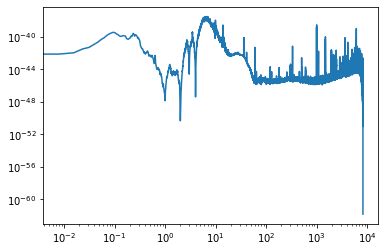

In [6]:
freq, Pxx = gwosc.estimate_psd_cvmfs(seg_sec=noise_interval//8, )
plt.loglog(freq, Pxx)
freq.size, Pxx.size

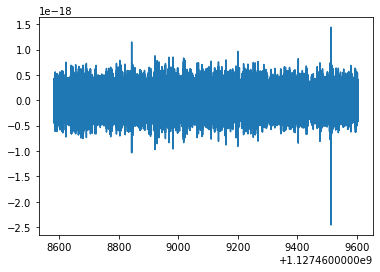

In [22]:
plt.plot(gwosc.time, gwosc.strain)

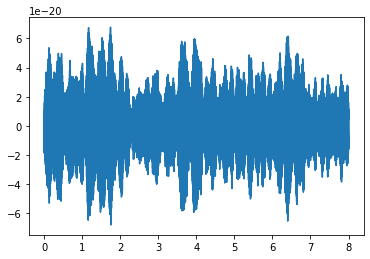

In [64]:
plt.plot(det.ifo.time_array, det.ifo.time_domain_strain)
# plt.xlim(left=det.ifo.time_array[-1550000], right=det.ifo.time_array[-1400000])

In [8]:
from gwtoolkit.gw import Detector


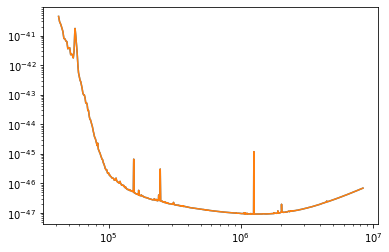

In [9]:
det = Detector('H1', sampling_frequency, 4096)
plt.loglog(det.power_spectral_density_array)
det.power_spectral_density_array

det.ifo.strain_data.set_from_time_domain_strain(gwosc.strain,
                                               sampling_frequency,
                                               4096,
                                               start_time=gwosc.start)
plt.loglog(det.power_spectral_density_array)

In [41]:
det.ifo.

'H1'

In [19]:
det.ifo.power_spectral_density

PowerSpectralDensity(psd_file='None', asd_file='/opt/conda/lib/python3.8/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')

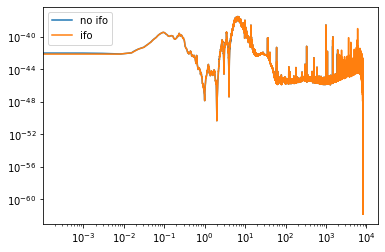

In [20]:
det.ifo.power_spectral_density = det.ifo.power_spectral_density.from_power_spectral_density_array(freq, Pxx)
# det.ifo.minimum_frequency = det.ifo.strain_data.minimum_frequency
plt.loglog(det.frequency_array, det.power_spectral_density_array,label='no ifo')
plt.loglog(det.ifo.power_spectral_density.frequency_array, 
           det.ifo.power_spectral_density.psd_array, label='ifo')
# plt.loglog(freq, Pxx, label='input')
plt.legend();

In [16]:
det.ifo.power_spectral_density._cache['frequency_array']

array([0.00000000e+00, 7.81250000e-03, 1.56250000e-02, ...,
       8.19198438e+03, 8.19199219e+03, 8.19200000e+03])

In [17]:
det.time_domain_strain

19:32 bilby INFO    : Generating frequency domain strain from given time domain strain.
19:32 bilby INFO    : Applying a tukey window with alpha=9.765625e-05, roll off=0.2


array([-7.31734869e-23, -5.50930580e-23, -3.76881462e-23, ...,
       -1.23691156e-22, -1.07678856e-22, -9.09641340e-23])

In [20]:
det.frequency_domain_strain

array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j, ...,
       3.34299041e-26-4.20722932e-30j, 3.34299162e-26-1.99934530e-30j,
       3.34299266e-26+0.00000000e+00j])

In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('..')
import matplotlib.pyplot as plt
from gwtoolkit.gw import Detector
sampling_frequency = 4096
duration = 8
det = Detector('H1', sampling_frequency, duration)

In [2]:
data_dir = '/workspace/zhaoty/dataset/O1_H1_All/'
noise_interval = 1024
selected_hdf_file_ratio = 0.05
num_length = 4
det.load_from_GWOSC(data_dir, noise_interval, selected_hdf_file_ratio, num_length)

Using data directory /workspace/zhaoty/dataset/O1_H1_All/ ...


In [3]:
len(det.gwosc.noise_timeline.hdf_files)

92

In [4]:
det.gwosc.update_randomly_strain()

In [6]:
freq, Pxx = det.gwosc.estimate_randomly_psd_cvmfs(seg_sec=2, random_timedomain_ratio=0.3)

(16385, 4092)
(16385, 1227)


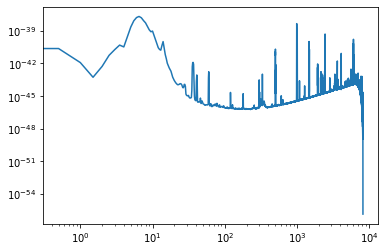

In [7]:
plt.loglog(freq, Pxx)

In [4]:
# det.gwosc.noise_timeline.hdf_files

In [5]:
det.gwosc.dq_bits

(0, 1, 2, 3)

In [7]:
det.gwosc.strain_multi.shape

(4, 16777216)

In [11]:
import scipy.signal

In [6]:
det.gwosc.update_strain()

In [7]:
det.gwosc.strain.shape

(16777216,)

In [23]:
# det.update_psd_from_GWOSC(seg_sec=1)

In [131]:
from scipy.signal import find_peaks
length = 1024
num_length = 1

dqbitmask = sum([2**i for i in det.gwosc.dq_bits])
injbitmask = sum([2**i for i in det.gwosc.inj_bits])

x = (det.gwosc.noise_timeline.timeline['h1_dq_mask'] > dqbitmask) * 1  # >? or >=?
x *= (det.gwosc.noise_timeline.timeline['h1_inj_mask'] > injbitmask) * 1  # >? or >=?
_, properties = find_peaks(x, plateau_size=length)

In [132]:
properties

{'plateau_sizes': array([3976, 4096, 3487, 4096, 2580, 1869, 1267, 1260, 4096, 3496, 4096,
        4096, 4096, 4096, 4096, 4096, 3691, 4096, 4096, 4096]),
 'left_edges': array([ 123000,  176128,  380928,  499712,  607593,  897024,  899853,
         912033, 1069056, 1077848, 1515520, 1732608, 1875968, 2084864,
        2269184, 2301952, 2359296, 2433024, 2527232, 2965504]),
 'right_edges': array([ 126975,  180223,  384414,  503807,  610172,  898892,  901119,
         913292, 1073151, 1081343, 1519615, 1736703, 1880063, 2088959,
        2273279, 2306047, 2362986, 2437119, 2531327, 2969599])}

In [133]:
index_segments = np.random.randint(len(properties['left_edges']), size=num_length)
index_segments

array([16])

In [112]:
index_time_l, index_time_r = properties['left_edges'][index_segments], properties['right_edges'][index_segments]
index_time_l, index_time_r

(array([1875968, 2301952,  499712,  176128]),
 array([1880063, 2306047,  503807,  180223]))

In [134]:
[(index_time_l[i], np.random.choice(range(index_time_r[i]+1-index_time_l[i]-length+1)) ) for i in range(num_length)]

[(1875968, 1224)]

718

<BarContainer object of 20 artists>

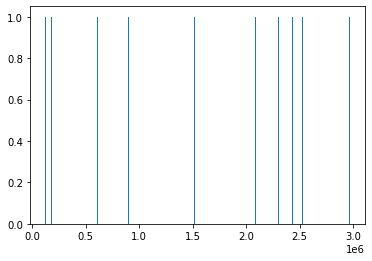

In [99]:
plt.bar(properties['left_edges'], height=1, width=properties['right_edges']-properties['left_edges'], 
        align='edge')

In [17]:
# addr = '/workspace/zhouy/megatron-gw/valid/500k-1.2b_100000'
# !ls -lht $addr

In [ ]:
# -------------------------------------------------------------------------
def _inj_dq_check(self, dqbitmask, injbitmask, length):
    """
    """
    # TODO only works for H1 signal-detector for now
    x = (self.timeline['h1_dq_mask'] > dqbitmask) * 1  # >? or >=?
    x *= (self.timeline['h1_inj_mask'] > injbitmask) * 1  # >? or >=?
    _, properties = find_peaks(x, plateau_size=length)

    index_segments = np.random.randint(len(properties['left_edges']))
    index_time_l, index_time_r = properties['left_edges'][index_segments], properties['right_edges'][index_segments]
    return index_time_l, np.arange(index_time_r+1-index_time_l-length+1)


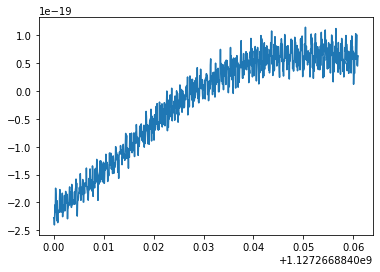

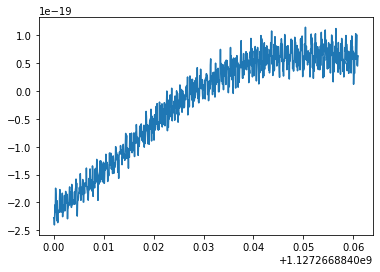

In [49]:
# det.update()
n = 1000
plt.plot(det.ifo.time_array[:n], det.ifo.time_domain_strain[:n])
plt.show()
plt.plot(det.gwosc.time[:n], det.gwosc.strain[:n])
# plt.xlim(right = det.gwosc.time[1000]);

In [43]:
np.allclose(det.gwosc.strain, det.time_domain_strain)

False

In [35]:
det.time_domain_strain.size

67108864

In [47]:
det.update_time_domain_strain_from_GWOSC(seg_sec=4)

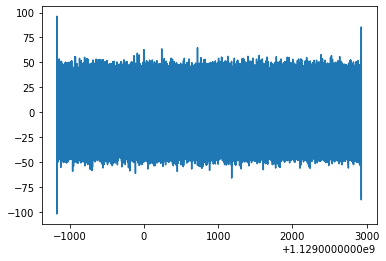

In [36]:
plt.plot(det.time_array, det.time_domain_whitened_strain)

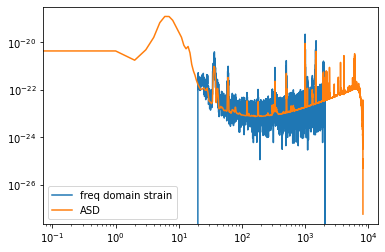

In [30]:
det.update()
plt.loglog(det.frequency_array, abs(det.frequency_domain_strain), label ='freq domain strain')
plt.loglog(det.ifo.power_spectral_density.frequency_array, det.ifo.power_spectral_density.asd_array, label= 'ASD')
plt.legend();

In [92]:
det.ifo.strain_data.set_from_time_domain_strain(det.gwosc.strain,
                                               det.gwosc.original_sampling_rate,
                                               # det.gwosc.noise_interval,
                                               time_array=det.gwosc.time)

In [96]:
assert np.allclose(det.gwosc.strain, det.ifo.time_domain_strain)
assert np.allclose(det.gwosc.time, det.ifo.time_array)

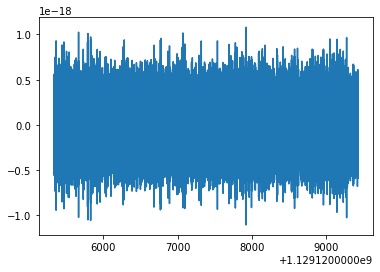

In [93]:
# det.update()
plt.plot(det.ifo.strain_data.time_array, det.ifo.time_domain_strain)

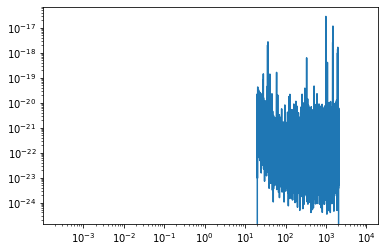

In [100]:
plt.loglog(det.ifo.frequency_array, abs(det.ifo.frequency_domain_strain))

In [28]:
import ray

def func1(i: int) -> int:
    return i + 1

def func2(i: int) -> int:
    return i * 2

def func3(i: int) -> int:
    return i % 3

# Create a dataset and then create a pipeline from it.
base = ray.data.range(1000000)
print(base)
# -> Dataset(num_blocks=200, num_rows=1000000, schema=<class 'int'>)
pipe = base.window(blocks_per_window=10)
print(pipe)
# -> DatasetPipeline(num_windows=20, num_stages=1)


Dataset(num_blocks=200, num_rows=1000000, schema=<class 'int'>)
DatasetPipeline(num_windows=20, num_stages=1)


In [29]:
# Applying transforms to pipelines adds more pipeline stages.
pipe = pipe.map(func1)
pipe = pipe.map(func2)
pipe = pipe.map(func3)
print(pipe)

DatasetPipeline(num_windows=20, num_stages=4)


In [2]:
import ray

# Create a Dataset of Python objects.
ds = ray.data.range(10000)
ds

2021-12-09 16:48:26,963	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265
2021-12-09 16:48:26,971	WARNING services.py:1816 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 66969600 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Dataset(num_blocks=200, num_rows=10000, schema=<class 'int'>)

In [8]:
ds.take(5)

[0, 1, 2, 3, 4]

In [4]:
ds.count()

10000

In [9]:
# Create a Dataset of Arrow records.
ds = ray.data.from_items([{"col1": i, "col2": str(i)} for i in range(10000)])

In [10]:
ds.show(5)

{'col1': 0, 'col2': '0'}
{'col1': 1, 'col2': '1'}
{'col1': 2, 'col2': '2'}
{'col1': 3, 'col2': '3'}
{'col1': 4, 'col2': '4'}


In [11]:
ds.schema()

col1: int64
col2: string

In [ ]:
from ray.da

In [15]:
import pandas as pd
# import dask.dataframe as dd

# Create a Dataset from a list of Pandas DataFrame objects.
pdf = pd.DataFrame({"one": [1, 2, 3], "two": ["a", "b", "c"]})
ds = ray.data.from_pandas([pdf])
ds

Dataset(num_blocks=1, num_rows=3, schema={one: int64, two: string})

In [16]:
ds = ray.data.range(10000)
ds = ds.map(lambda x: x * 2)

Map Progress: 100%|██████████████████████████████████████| 200/200 [00:00<00:00, 1411.87it/s]
